<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/07_Milestone_Project_1_%F0%9F%8D%94%F0%9F%91%81_Food_Vision_Big%E2%84%A2_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
!pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.3 MB/s eta 0:00:00


# Load

In [ ]:
(train_ds, test_ds), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"], # https://www.tensorflow.org/datasets/catalog/food101
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

# Explore

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpynu0l8d3tfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [6]:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/features/ClassLabel?hl=en
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
for i, (sample_image, sample_label) in enumerate(train_ds.take(3)):
  print("Sample:", i)
  print("Image:", sample_image.shape, sample_image.dtype.name, sample_image[1:5,1,1].numpy())
  print("Label:", sample_label.dtype.name, sample_label.numpy())

Sample: 0
Image: (512, 512, 3) uint8 [ 90  92  98 103]
Label: int64 31
Sample: 1
Image: (512, 384, 3) uint8 [0 0 0 0]
Label: int64 19
Sample: 2
Image: (341, 512, 3) uint8 [ 2  6  9 12]
Label: int64 98


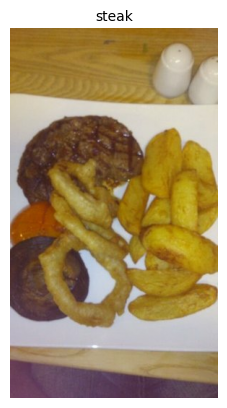

In [8]:
one_image, one_label = list(train_ds.take(1).as_numpy_iterator())[0]
plt.imshow(one_image/255.)
plt.axis("off")
plt.title(class_names[one_label], fontsize=10)
plt.show()

# Prepare/Optimize

In [9]:
def preprocess_image(image, label):
  """Resize and cast to float32."""
  proc_image = tf.image.resize(image, [224, 224])
  proc_image = tf.cast(proc_image, tf.float32)
  return proc_image, label

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Feature extraction model

In [10]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

def create_model(model_name):
  # define layers
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  feature_extractor = tf.keras.layers.GlobalAveragePooling2D(name="feature_extraction")
  logit_layer = tf.keras.layers.Dense(len(class_names), name="logits")
  softmax = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax")
  # define model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(224, 224, 3), name="inputs")
  x = base_model(inputs, training=False)
  x = feature_extractor(x)
  x = logit_layer(x)
  outputs = softmax(x)
  model = tf.keras.Model(inputs, outputs, name=model_name)
  return model

from datetime import datetime

def create_tensorboard(model_name):
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
      profile_batch=(500, 520),
      histogram_freq=1,)
  return tensorboard_callback

In [11]:
fe_model = create_model("feature_extraction")
fe_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
fe_model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 feature_extraction (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 logits (Dense)              (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                 

In [12]:
for layer in fe_model.layers:
  print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

inputs float32 True <Policy "float32">
efficientnetv2-b0 float32 False <Policy "mixed_float16">
feature_extraction float32 True <Policy "mixed_float16">
logits float32 True <Policy "mixed_float16">
softmax float32 True <Policy "float32">


The layers of EfficientNet are frozen and the mixed precision policy is enabled.

In [13]:
fe_history = fe_model.fit(train_ds,
                          epochs=3,
                          validation_data=test_ds,
                          validation_steps=len(test_ds)//5,
                          callbacks=[create_tensorboard(fe_model.name)]
                          )

Epoch 1/3
2368/2368 [==============================] - 92s 32ms/step - loss: 1.7452 - accuracy: 0.5769 - val_loss: 1.1656 - val_accuracy: 0.6930
Epoch 2/3
2368/2368 [==============================] - 76s 32ms/step - loss: 1.2106 - accuracy: 0.6877 - val_loss: 1.0563 - val_accuracy: 0.7146
Epoch 3/3
2368/2368 [==============================] - 75s 31ms/step - loss: 1.0632 - accuracy: 0.7223 - val_loss: 1.0142 - val_accuracy: 0.7261


In [14]:
fe_model.save("models/feature_extraction_model")

# Model evaluation

In [15]:
eval_res_fe_mod = fe_model.evaluate(test_ds)

790/790 [==============================] - 20s 25ms/step - loss: 1.0024 - accuracy: 0.7288


In [16]:
from tqdm.auto import tqdm

top1_acc_metric = tf.keras.metrics.CategoricalAccuracy()
top5_acc_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
y_true = []
y_proba = []
y_pred = []
wrong_samples = []

pbar = tqdm(test_ds)

for images, labels in pbar:
  one_hot_labels = tf.one_hot(labels, depth=len(class_names))
  pred_probs = fe_model.predict(images, verbose=0)
  pred_confs = tf.reduce_max(pred_probs, axis=1)
  pred_max = tf.argmax(pred_probs, axis=1)
  hi_conf_wrong_preds = (labels != pred_max) & (pred_confs > 0.9)
  wrong_samples.extend(list(
      zip(
        list(map(class_names.__getitem__, pred_max[hi_conf_wrong_preds].numpy())),
        list(map(class_names.__getitem__, labels[hi_conf_wrong_preds].numpy())),
        pred_confs[hi_conf_wrong_preds].numpy(),
        tf.gather(images, tf.reshape(tf.where(hi_conf_wrong_preds), -1, 1)).numpy()
  )))
  y_true.extend(labels.numpy())
  y_proba.extend(pred_probs)
  y_pred.extend(pred_max.numpy())
  top1_acc_metric.update_state(one_hot_labels, pred_probs)
  top5_acc_metric.update_state(one_hot_labels, pred_probs)
  top1_acc = top1_acc_metric.result().numpy()
  top5_acc = top5_acc_metric.result().numpy()
  pbar.set_postfix({"Top-1 Accuracy": f"{top1_acc:.4f}",
                    "Top-5 Accuracy": f"{top5_acc:.4f}"})

  0%|          | 0/790 [00:00<?, ?it/s]

In [17]:
from sklearn import metrics

print(f"""
Top-1 Accuracy={metrics.accuracy_score(y_true, y_pred):.4f}
Top-5 Accuracy={metrics.top_k_accuracy_score(y_true, y_proba, k=5):.4f}
""")


Top-1 Accuracy=0.7288
Top-5 Accuracy=0.9217



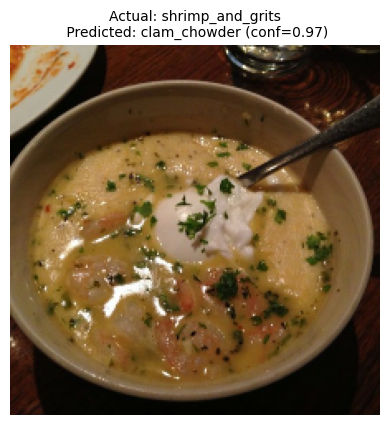

In [18]:
import random

wrong_label, correct_label, wrong_confidence, wrong_image = wrong_samples[random.choice(range(len(wrong_samples)))]
plt.imshow(wrong_image/255.)
plt.axis("off")
plt.title(f"Actual: {correct_label}\n Predicted: {wrong_label} (conf={wrong_confidence:.2f})", fontsize=10)
plt.show()

In [19]:
print(metrics.classification_report(y_true, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.59      0.49      0.54       250
         baby_back_ribs       0.76      0.71      0.73       250
                baklava       0.85      0.72      0.78       250
         beef_carpaccio       0.80      0.74      0.77       250
           beef_tartare       0.60      0.63      0.61       250
             beet_salad       0.68      0.58      0.62       250
               beignets       0.87      0.78      0.82       250
               bibimbap       0.92      0.86      0.89       250
          bread_pudding       0.55      0.57      0.56       250
      breakfast_burrito       0.61      0.70      0.65       250
             bruschetta       0.48      0.69      0.56       250
           caesar_salad       0.79      0.74      0.76       250
                cannoli       0.74      0.78      0.76       250
          caprese_salad       0.70      0.67      0.69       250
            carrot_cake 

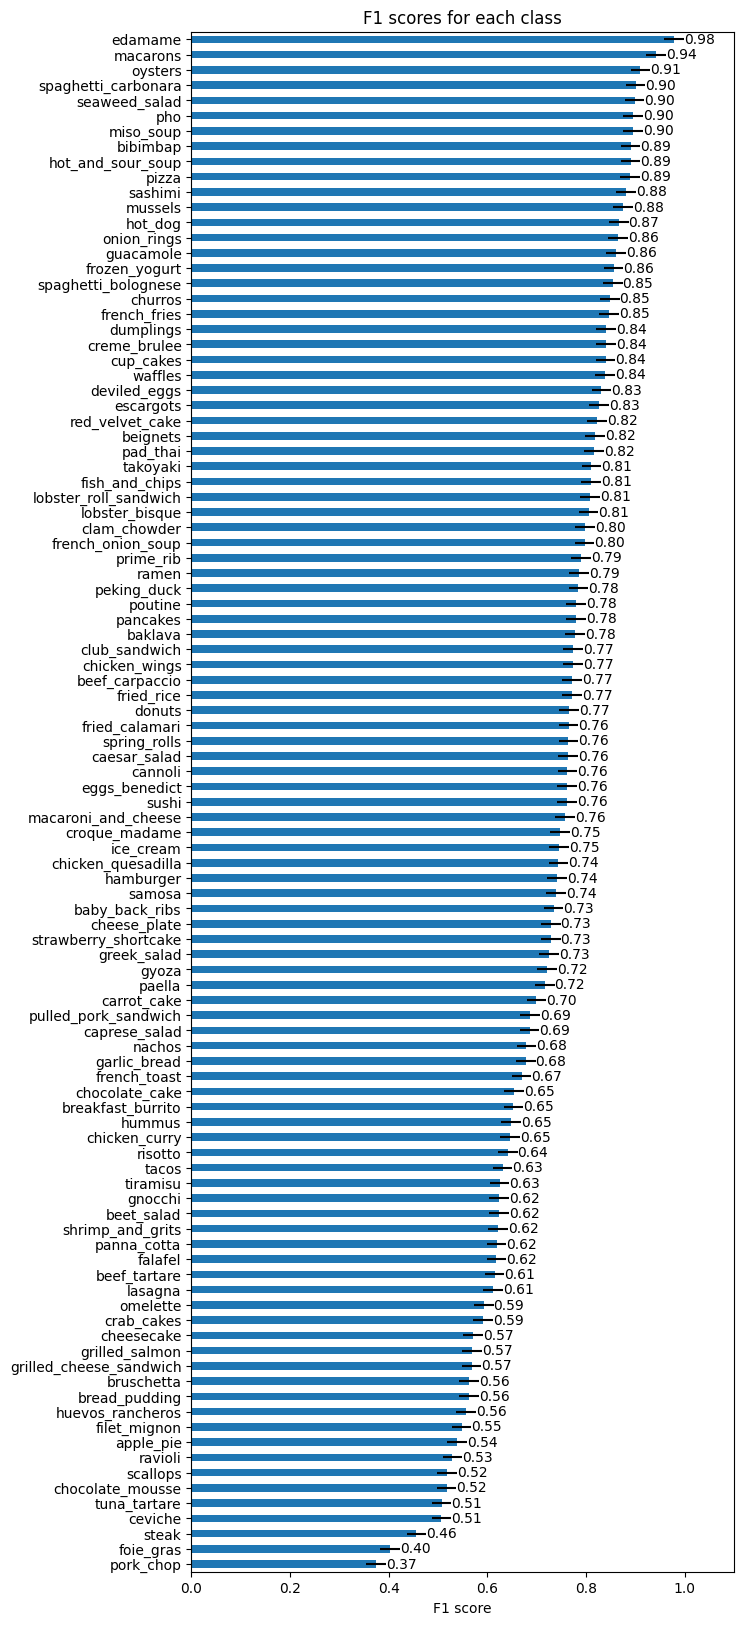

In [20]:
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 20))
(
  pd.DataFrame(metrics.classification_report(y_true, y_pred,
                                             target_names=class_names,
                                             output_dict=True))
  .T
  .iloc[:len(class_names), 2]
  .sort_values()
  .plot(kind="barh", ax=ax, fontsize=10, xerr=[0.02] * len(class_names))
)
plt.title("F1 scores for each class")
ax.bar_label(ax.containers[1], fmt="%.2f")
ax.set_xlim(right=1.1)
ax.set_xlabel("F1 score")
plt.show()

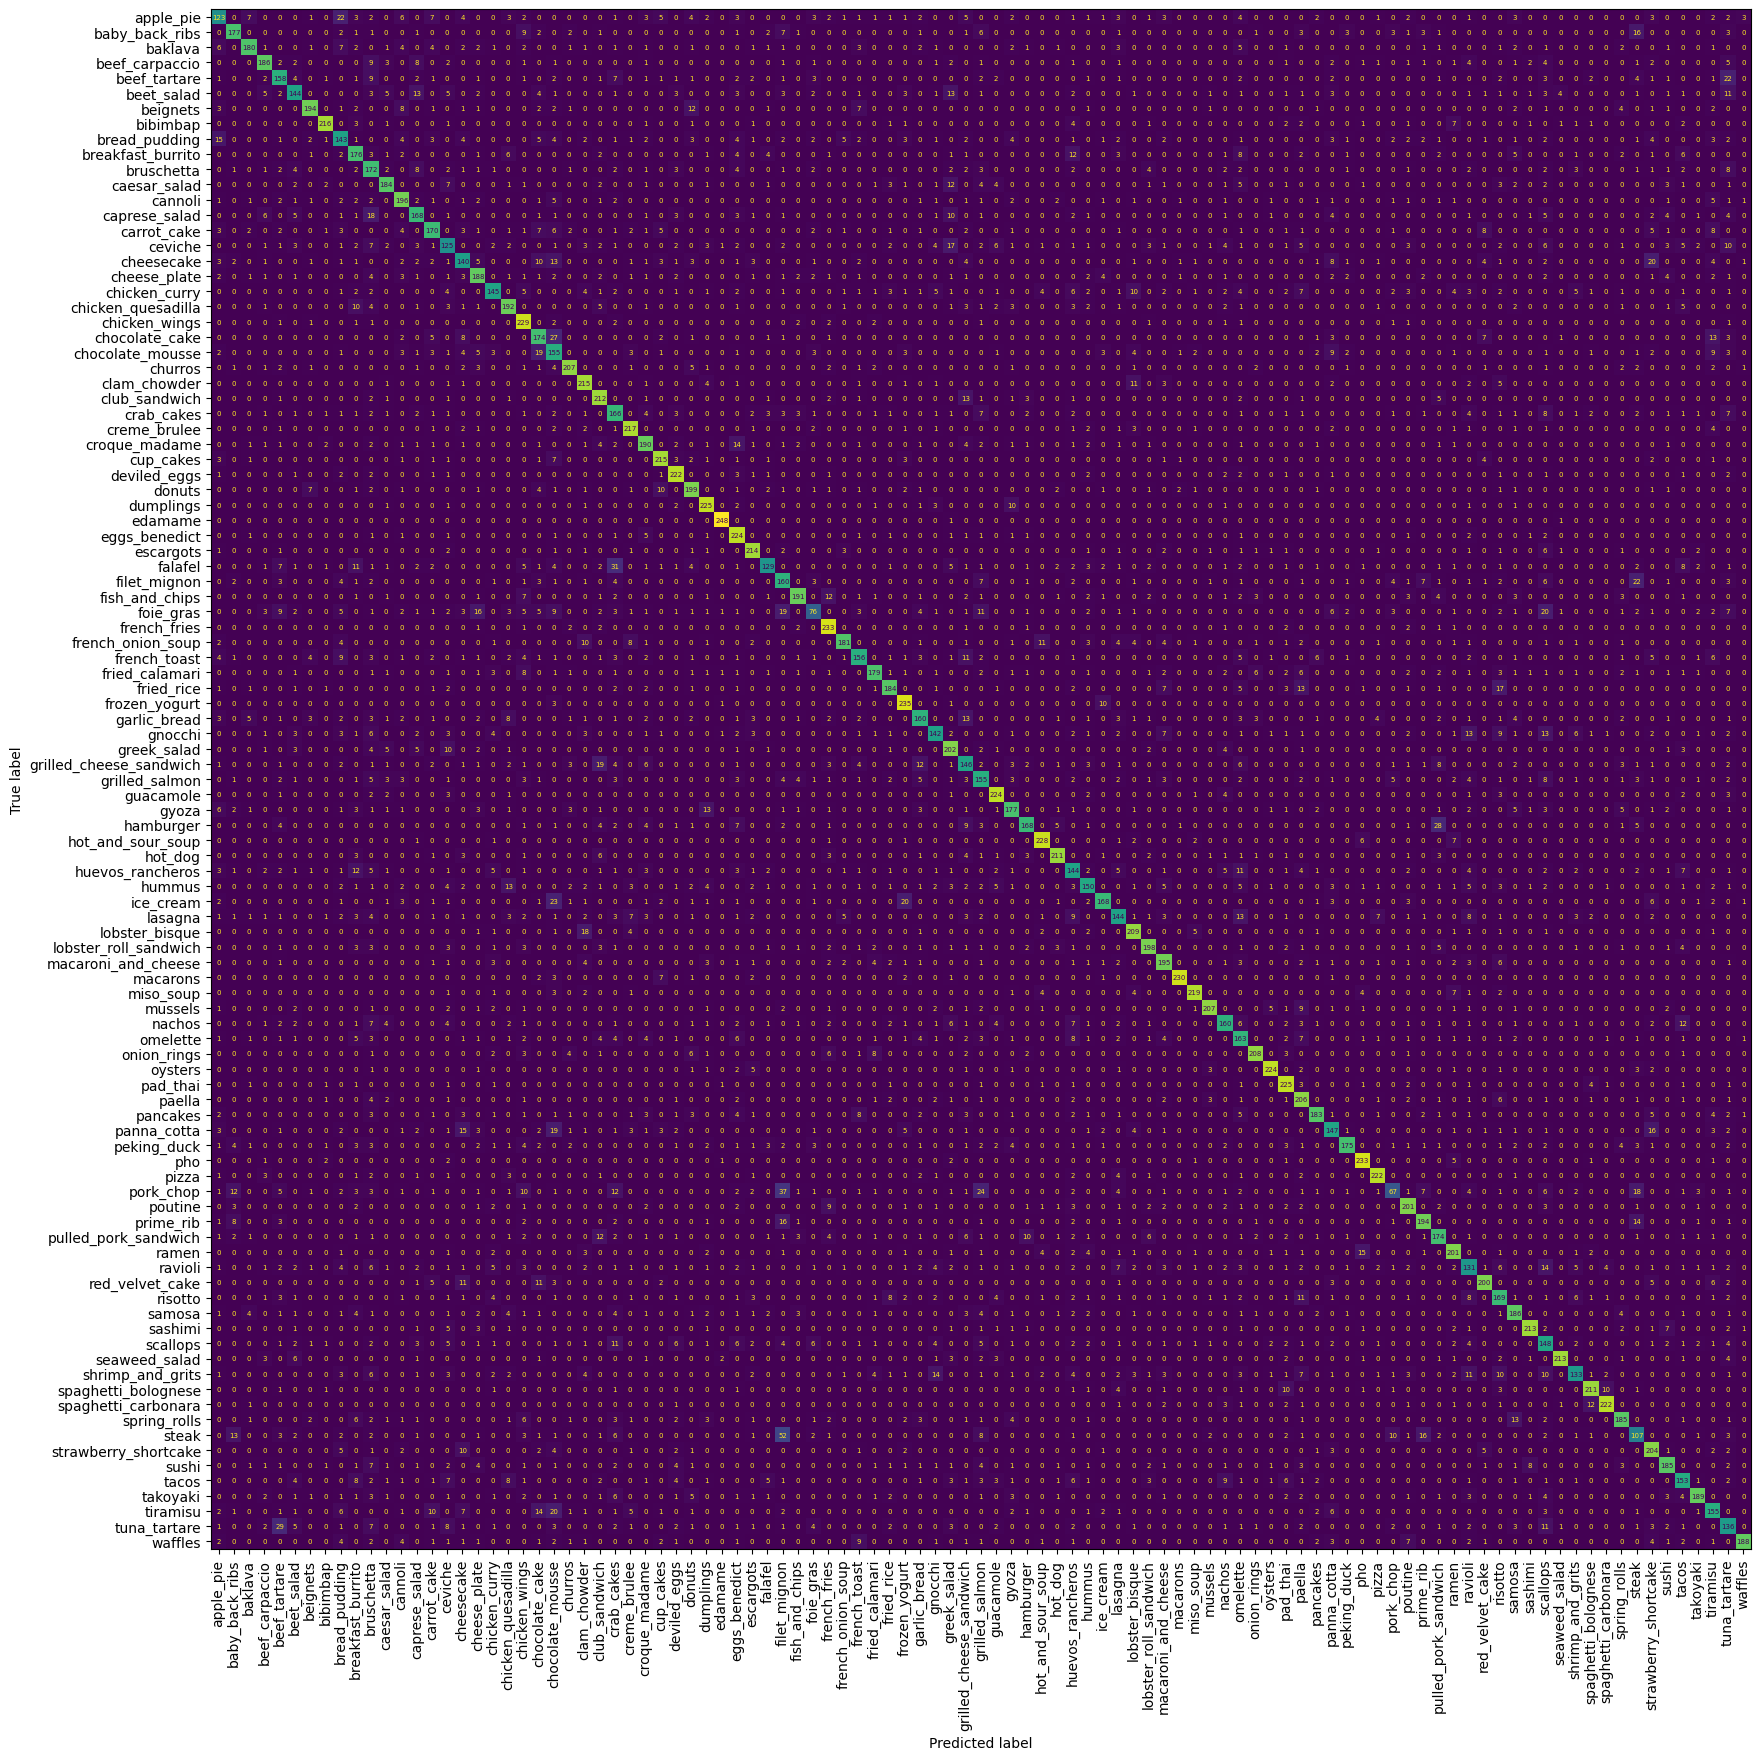

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    ax=ax,
    xticks_rotation="vertical",
    text_kw=dict(fontsize=5),
    colorbar=False
)
plt.show()

# Fine-tuned model

In [22]:
ft_model = tf.keras.models.load_model("models/feature_extraction_model")
ft_model._name = "fine_tuned"
for layer in ft_model.layers:
  layer.trainable = True
ft_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=["accuracy"])
ft_model.summary()

Model: "fine_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 feature_extraction (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 logits (Dense)              (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                                 
Total params: 6048693 (23.07 MB)
Trainable params: 59880

In [23]:
for layer in ft_model.layers:
  print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

inputs float32 True <Policy "float32">
efficientnetv2-b0 float32 True <Policy "mixed_float16">
feature_extraction float32 True <Policy "mixed_float16">
logits float32 True <Policy "mixed_float16">
softmax float32 True <Policy "float32">


In [24]:
def create_earlystopping():
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True)
  return early_stopping_callback

def create_learningreduction():
  lr_reduction_callback = tf.keras.callbacks.ReduceLROnPlateau(
      factor=0.2,
      patience=2,
      min_lr=1e-7
  )
  return lr_reduction_callback

In [25]:
ft_history = ft_model.fit(train_ds,
                          epochs=100,
                          validation_data=test_ds,
                          validation_steps=len(test_ds)//5,
                          callbacks=[create_tensorboard(ft_model.name),
                                     create_earlystopping(),
                                     create_learningreduction()]
                          )

Epoch 1/100
2368/2368 [==============================] - 296s 104ms/step - loss: 0.8659 - accuracy: 0.7661 - val_loss: 0.7578 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 234s 99ms/step - loss: 0.5124 - accuracy: 0.8576 - val_loss: 0.7205 - val_accuracy: 0.8026 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 233s 98ms/step - loss: 0.2644 - accuracy: 0.9239 - val_loss: 0.8178 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 234s 99ms/step - loss: 0.1352 - accuracy: 0.9591 - val_loss: 0.9259 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 234s 99ms/step - loss: 0.0259 - accuracy: 0.9943 - val_loss: 0.9630 - val_accuracy: 0.8097 - lr: 2.0000e-05
